# Customer Segmentation Workflow 1- Data Exploration and Feature Engineering

** These notebooks use an anonymised excerpt of a retailer dataset. The goals is to segment customers by both aggregate sales patterns and specific items purchased and to provide more tailored services and improve marketing to customers based on segments.**

This is part 1 of a 2 part series presenting a customer segmentation workcycle. The dataset is a log of item purchase transactions with an associated customer id.

The goal is to build a workflow for performing customer segmentation through clustering.


In [1]:

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns


In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
df = pd.read_csv('tx_log.csv')

This dataset is clean and requires very little pre-processing. The dataset is small containing c.35,000 individual transactions with 8 features per transaction.

In [5]:
df.shape

(35116, 8)

In [6]:
# First 10 rows of data
display_all(df.T)

0                          1      \
InvoiceNo                       536370                     536370   
StockCode                        22728                      22727   
Description  ALARM CLOCK BAKELIKE PINK  ALARM CLOCK BAKELIKE RED    
Quantity                            24                         24   
InvoiceDate               12/1/10 8:45               12/1/10 8:45   
UnitPrice                         3.75                       3.75   
CustomerID                       12583                      12583   
Country                         France                     France   

                                  2                                3      \
InvoiceNo                        536370                           536370   
StockCode                         22726                            21724   
Description  ALARM CLOCK BAKELIKE GREEN  PANDA AND BUNNIES STICKER SHEET   
Quantity                             12                               12   
InvoiceDate                12/1/10 8:45                     12/1/10 8:45   
UnitPrice                          3.75                             0.85   
CustomerID                        12583                            12583   
Country                          France                           France   

                        4                            5      \
InvoiceNo              536370                       536370   
StockCode               21883                        10002   
Description  STARS GIFT TAPE   INFLATABLE POLITICAL GLOBE    
Quantity                   24                           48   
InvoiceDate      12/1/10 8:45                 12/1/10 8:45   
UnitPrice                0.65                         0.85   
CustomerID              12583                        12583   
Country                France                       France   

                                          6      \
InvoiceNo                                536370   
StockCode                                 21791   
Description  VINTAGE HEADS AND TAILS CARD GAME    
Quantity                                     24   
InvoiceDate                        12/1/10 8:45   
UnitPrice                                  1.25   
CustomerID                                12583   
Country                                  France   

                                       7      \
InvoiceNo                             536370   
StockCode                              21035   
Description  SET/2 RED RETROSPOT TEA TOWELS    
Quantity                                  18   
InvoiceDate                     12/1/10 8:45   
UnitPrice                               2.95   
CustomerID                             12583   
Country                               France   

                                           8                    9      \
InvoiceNo                                 536370               536370   
StockCode                                  22326                22629   
Description  ROUND SNACK BOXES SET OF4 WOODLAND   SPACEBOY LUNCH BOX    
Quantity                                      24                   24   
InvoiceDate                         12/1/10 8:45         12/1/10 8:45   
UnitPrice                                   2.95                 1.95   
CustomerID                                 12583                12583   
Country                                   France               France   

                               10                        11     \
InvoiceNo                     536370                    536370   
StockCode                      22659                     22631   
Description  LUNCH BOX I LOVE LONDON  CIRCUS PARADE LUNCH BOX    
Quantity                          24                        24   
InvoiceDate             12/1/10 8:45              12/1/10 8:45   
UnitPrice                       1.95                      1.95   
CustomerID                     12583                     12583   
Country                       France                    France   

                     

In [7]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

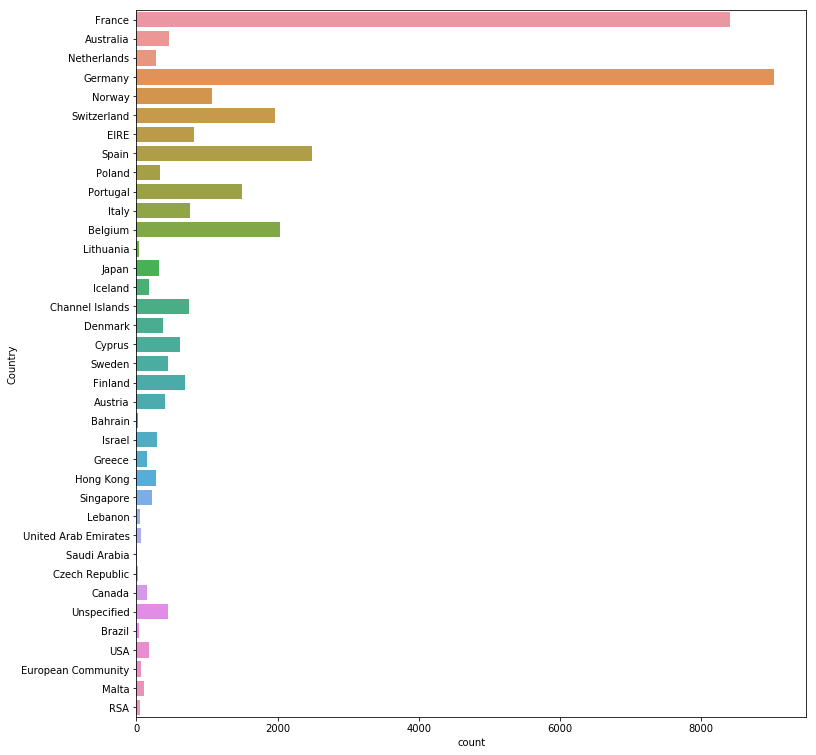

In [8]:
# transactions by country
plt.figure(figsize=(12,13))
# Bar plot by country
sns.countplot(y='Country', data=df)

In [7]:
# Missing data by feature
display_all(df.isnull().sum()/df.shape[0]*100)


InvoiceNo      0.000000
StockCode      0.000000
Description    0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     4.038045
Country        0.000000
dtype: float64

The intention is to cluster by customer segments and therefore we can do nothing with 4% of rows that are missing customer ids.

In [9]:
df = df.dropna(subset=['CustomerID'])

Equality operations between float values are sometimes unpredictable therefore the customerid is converted to an int type.

In [10]:
df['CustomerID'] = df.CustomerID.astype(int)

In [11]:
df["CustomerID"].nunique()

414

In [12]:
#Average number of transactions per customer
df["CustomerID"].value_counts().mean()

81.39613526570048

Text(0.5,1,'Number of purchses per customer')

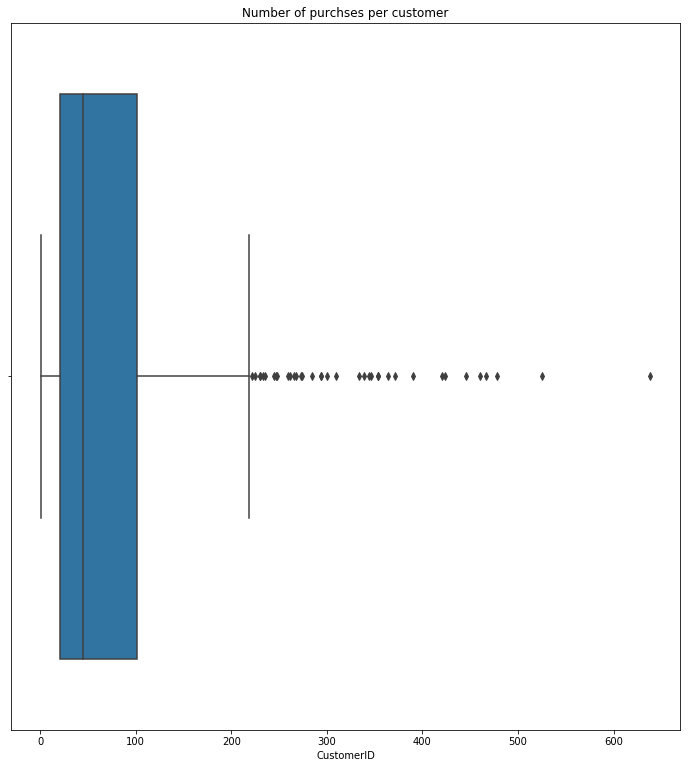

In [15]:
plt.figure(figsize=(12,13))
sns.boxplot(x=df["CustomerID"].value_counts()).set_title("Number of purchses per customer")

**Create a sales feature to capture the value of each transaction**

In [16]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

** Feature engineering and data aggregation**

The data is still at the individual transaction level.
It will have to be rolled up into a number of customer-level and invoice level features to allow customer-level and item-level segmentation.**

First sales data is aggregated by customer and by invoice.


In [17]:
def invoice_level_agg(x):
    names = {"Cart_Value": x["Sales"].sum()}
    return pd.Series(names, index=["Cart_Value"])

In [18]:
cart_data =  df.groupby(["CustomerID", "InvoiceNo"]).apply(invoice_level_agg)

In [19]:
cart_data.reset_index(inplace=True)


**The following customer-level features will be engineered:**
* 'total_transactions' - the total number of unique transactions for each customer.
* 'total_products'- the total number of products purchased by each customer 
* 'total_unique_products' - the number of unique products purchased by each customer.
* 'total_sales' - the total sales for each customer.
* 'avg_product_value'- the average value of the products purchased by the customer.

In [20]:
def customer_level_agg(x):
    names = {"Total_Transactions":x["InvoiceNo"].nunique(),
            "Total_Products": x["StockCode"].count(),
            "Total_Unique_Products": x["StockCode"].nunique(),
            "Total_Sales": x["Sales"].sum(),
            "Average_Product_Value": x["Sales"].mean()}
    
    
    
    return pd.Series(names, index=["Total_Transactions", "Total_Products","Total_Unique_Products", \
                                   "Total_Sales", "Average_Product_Value"])

In [21]:
customer_data = df.groupby(["CustomerID"]).apply(customer_level_agg)

**Finally cart/invoice-level data is aggregated**

In [24]:
def cart_level_agg(x):
    names = {  
        "Avg_Cart_Value": x["Cart_Value"].mean(),
        "Min_Cart_Value": x["Cart_Value"].min(),
        "Max_Cart_Value": x["Cart_Value"].max()}
    
    return pd.Series(names, index=["Avg_Cart_Value", "Min_Cart_Value", "Max_Cart_Value"])   
    

In [25]:
agg_cart_data = cart_data.groupby("CustomerID").apply(cart_level_agg)

In [26]:
# Join together customer-level and cart-level features
customer_df = customer_data.join(agg_cart_data)


In [27]:
customer_df.dtypes

Total_Transactions       float64
Total_Products           float64
Total_Unique_Products    float64
Total_Sales              float64
Average_Product_Value    float64
Avg_Cart_Value           float64
Min_Cart_Value           float64
Max_Cart_Value           float64
dtype: object

Customer_df will be used in a segmentation analysis in the second notebook

In [28]:
# Save analytical base table
customer_df.to_csv('analytical_base_table.csv')

## Item-Level Segmentation

In [29]:
# Get item_dummies
item_dummies = pd.get_dummies(df.StockCode )

# Add CustomerID to item_dummies.Note this uses the original tx-level dataframe
item_dummies['CustomerID'] = df.CustomerID

In [30]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()
# Display first 5 rows of item_data
item_data.head(5)

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,...,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5


In [31]:
# Save item_data.csv
item_data.to_csv('item_data.csv')

In [32]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(20).index

In [33]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

# Shape of remaining dataframe
top_20_item_data.shape

(414, 20)

In [36]:
# Display first 5 rows of top_20_item_data
top_20_item_data.head()

,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [37]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('threshold_item_data.csv')